<a href="https://colab.research.google.com/github/KSURAJ25/KSURAJ25/blob/main/Object_Detection_and_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection and Image Segmentation



In [1]:
!pip install -q torch torchvision

## Image Segmentation – Pretrained FCN

In [2]:

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = torchvision.datasets.OxfordIIITPet(
    root="data",
    split="trainval",
    target_types="segmentation",
    download=True,
    transform=transform,
    target_transform=transform
)

loader = DataLoader(dataset, batch_size=2, shuffle=True)


100%|██████████| 792M/792M [00:29<00:00, 27.1MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 12.2MB/s]


In [3]:

model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(512, 3, kernel_size=1)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model.train()
for images, masks in loader:
    images = images.to(device)
    masks = masks.to(device).squeeze(1).long()

    optimizer.zero_grad()
    outputs = model(images)["out"]
    loss = criterion(outputs, masks)
    loss.backward()
    optimizer.step()

    print("Training loss:", loss.item())
    break


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


100%|██████████| 135M/135M [00:01<00:00, 93.2MB/s]


Training loss: 1.0679409503936768


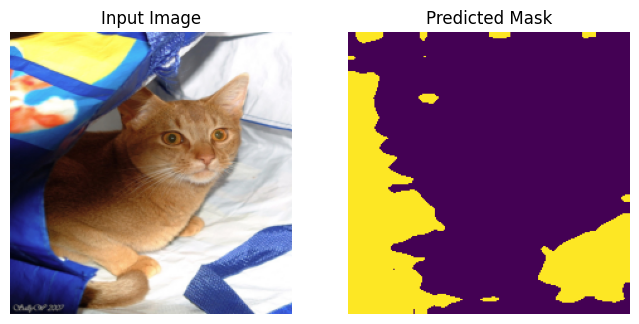

In [4]:

model.eval()
with torch.no_grad():
    img, _ = dataset[0]
    pred = model(img.unsqueeze(0).to(device))["out"]
    mask = torch.argmax(pred, dim=1).cpu().squeeze()

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img.permute(1,2,0))
plt.title("Input Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask)
plt.title("Predicted Mask")
plt.axis("off")
plt.show()


## Object Detection – Pretrained Faster R-CNN

In [7]:

from torchvision.models.detection import fasterrcnn_resnet50_fpn
from PIL import Image
import matplotlib.patches as patches

detector = fasterrcnn_resnet50_fpn(pretrained=True)
detector.eval().to(device)

# Upload an image named sample.jpg
img = Image.open("sample.jpg").convert("RGB")
img_tensor = transforms.ToTensor()(img).to(device)

with torch.no_grad():
    outputs = detector([img_tensor])[0]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
from google.colab import files

# This will open a file selection dialog. Please select your 'sample.jpg' file.
uploaded = files.upload()

Saving sample.jpg to sample.jpg


After uploading, please re-run the cell with the object detection code (`cell_id: 80f0a17c`).

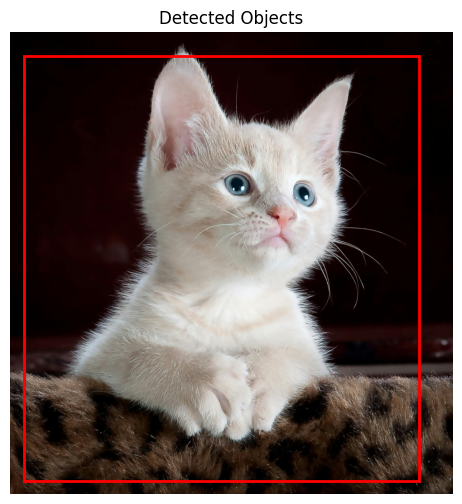

In [8]:

plt.figure(figsize=(6,6))
plt.imshow(img)
ax = plt.gca()

for box, score in zip(outputs["boxes"], outputs["scores"]):
    if score > 0.7:
        x1, y1, x2, y2 = box.cpu()
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                 linewidth=2, edgecolor="r", facecolor="none")
        ax.add_patch(rect)

plt.title("Detected Objects")
plt.axis("off")
plt.show()
